
## Sensitivity Analysis on AlphaPEM using Sobol Method (N = 1024)

In this notebook, we study how different input parameters affect the behavior of the AlphaPEM model using Sobol sensitivity analysis. The model takes 13 input features, including operating conditions and physical parameters.

To do this, we:

* Generate Sobol samples using the SALib library with a base size of N = 1024.
* Run the AlphaPEM model on these samples to produce polarization curves.
* Compute the area under the polarization curve (AUC) in three regions of current density:

  * ***Activation;*** 0.0 to 0.4 A/cm²
  * ***Ohmic:*** 0.4 to 1.6 A/cm²
  * ***Mass transport:*** above 1.6 A/cm²
* Use these regional AUCs as the target outputs for sensitivity analysis.

If the cell voltage becomes negative during simulation, we treat it as zero from that point onward. This makes sure the AUC values reflect only physically meaningful parts of the curve.

This helps us understand which inputs matter the most in each current density region of the fuel cell's operation.


In [18]:
import os
import sys
import pandas as pd
from omegaconf import OmegaConf

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="SALib")

# Modules from our project
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.analysis.sensitivity import SensitivityAnalyzer
from src.validity.validity_criteria import validate_polarization_curves
from src.FE.FE_formatting import expand_column_to_columns,parse_dependent_parameters,load_parameter_ranges
from src.FE.FE_imputation import compute_nearest_neighbors,aggregate_knn_curves
from src.FE.auxiliar_func_FE import (
    create_sobol_sample_dataframe,run_sobol_convergence_analysis_for_region,build_sobol_summary_table,select_top_features,run_sobol_analysis_for_region)
from src.FE.FE_plotting import plot_sobol_index_convergence,plot_top_k_rankings_across_regions,plot_sobol_region_barplot
from src.visualization.polarization import plot_polarization_curves
from src.sampling.sampler import run_simulations

## Utils

In [19]:
# --- Load parameter names from config ---
param_config,parameter_ranges, parameter_names= load_parameter_ranges('../configs/param_config.yaml')

# Add 'ifc' manually if you ever include it in plots
if 'ifc' not in parameter_names:
    parameter_names.append('ifc')

# --- Define consistent color map for all features ---
COLORS = OmegaConf.load('../configs/colors_cfg.yaml')['COLORS']
FEATURE_COLOR_MAP = {feat: COLORS[i % len(COLORS)] for i, feat in enumerate(parameter_names)}

## 1. Definition of problem + sampling

### 1.1 Generating Sobol samples

In this step, we create the input samples for sensitivity analysis using the Sobol method.
Sobol sequences are special sets of numbers that cover the space of possible inputs very evenly. This helps us explore the whole range of values for each input parameter without needing too many samples.

We use the `sobol_sample` function from SALib to generate a sample matrix with a base size of `N = 1024`. Each row is one input configuration that we will send to the AlphaPEM model. The result is stored in a DataFrame for easy processing later.


#### Cleaning and preparing the samples

Some of our input parameters are discrete (see <code>e</code>), meaning they can only take a few fixed values (like 3, 4, or 5). The Sobol generator gives continuous values, so here we round each sampled value to the nearest valid one for those parameters.

Finally, we create a unique ID (`config_id`) for every row. This helps us track each input configuration later. We also store the row index to make merging easier.

In [20]:
df_param_values_final,SA = create_sobol_sample_dataframe(param_config=param_config,parameter_ranges=parameter_ranges, N=1024, seed=42, calculate_second_order=True)
df_param_values_final.head(3)

,config_id,index,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,Re,i0_c_ref,kappa_co,kappa_c
0,0094c64f8fdda33260ed63c492d142bc880a650b617e77...,0,345.930884,268442.555293,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,5,0.000001,42.263896,31.826572,0.95265
1,732f012ec39bdcb105868dbabddf45c3d1be6262121e97...,1,350.821056,268442.555293,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,5,0.000001,42.263896,31.826572,0.95265
2,9cee6cbca778100f2a177430c2227fac9d62d9ba6514c9...,2,345.930884,201916.980138,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,5,0.000001,42.263896,31.826572,0.95265


In [25]:
df_param_values_final[df_param_values_final["config_id"] == "3e05decdf39c746fb4de44179361ad9f89147fc7b2ede1ffb4da324ecbaead1a"]

,index,config_id,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,Re,i0_c_ref,kappa_co,kappa_c
24877,24877,3e05decdf39c746fb4de44179361ad9f89147fc7b2ede1...,342.224261,280108.099058,1.537243,0.18472,0.732007,1.629209,0.385605,0.240976,4,0.000004,26.534082,16.916556,2.29321


In [ ]:
# Uncomment to save the design matrix
# df_param_values_final.to_pickle("../data/designs/sobol_design_matrix_N1024.pkl")

#### Save the design matrix for sampling
To run the previously defined configurations, follow the instructions described in the notebook `01_AlphaPEM_simulation_guide.ipynb`.
You can then execute the simulations either in parallel within this notebook or directly from the console.

For convenience, we have implemented the function `run_simulations` in this notebook. However, running the simulations from the console (recommended) requires obtaining the configuration skeleton provided in the referenced notebook.

The next cell is therefore optional. What is essential is that, after generating the design matrix, you must run the simulations and later load the results in section `1.2 Loading simulation results` of this notebook.

In [ ]:
# Example: Simulating 5 configurations
df_param_values_final.iloc[:5,].to_pickle("../data/designs/example_sobol_design_matrix_N5.pkl")

In [39]:
run_simulations(design_df_path = "../data/designs/example_sobol_design_matrix_N5.pkl",
                output_name = "notebook_parallel_demo_5")


Return code: 0

--- STDOUT ---
 Parallel AlphaPEM: 5 rows | 4 worker chunk(s) | workers=4
Temp dir: ..\data\raw\temp\notebook_parallel_demo_5
Worker 3: done | ok=1, err=0 â†’ worker_notebook_parallel_demo_5_core3.pkl
Chunk saved â†’ worker_notebook_parallel_demo_5_core3.pkl (ok=1, err=0)
Worker 2: done | ok=1, err=0 â†’ worker_notebook_parallel_demo_5_core2.pkl
Chunk saved â†’ worker_notebook_parallel_demo_5_core2.pkl (ok=1, err=0)
Worker 1: done | ok=1, err=0 â†’ worker_notebook_parallel_demo_5_core1.pkl
Chunk saved â†’ worker_notebook_parallel_demo_5_core1.pkl (ok=1, err=0)
Worker 0: done | ok=2, err=0 â†’ worker_notebook_parallel_demo_5_core0.pkl
Chunk saved â†’ worker_notebook_parallel_demo_5_core0.pkl (ok=2, err=0)
Final results â†’ ..\data\raw\notebook_parallel_demo_5_simulations.pkl
Final errors  â†’ ..\data\raw\notebook_parallel_demo_5_sim_errors.csv
Totals        â†’ ok=5, err=0


--- STDERR ---
 d:\Users\kju10\Documents\LMU-STATISTICS & DATA SCIENCE MASTER\WS2425\Consulting\

In [7]:
results_path = "../data/raw/notebook_parallel_demo_5_simulations.pkl"
df5_sampled = pd.read_pickle(results_path)

In [8]:
df5_sampled.head(3)

,config_id,index,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,...,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,Ucell_31
0,f08c07abbd89c1c9b63fb75cd3c24c5580b1d9dfeeb7e8...,4,345.930884,268442.555293,2.632184,0.145859,0.624485,3.519634,0.324444,0.240594,...,0.738852,0.729371,0.719911,0.710484,0.701083,0.691683,0.682266,0.672816,0.663316,0.653751
0,58549ad37fc1b48d631b9780b6a1302963afea4c952cf9...,3,345.930884,268442.555293,1.789606,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.726462,0.716607,0.706750,0.696888,0.686996,0.677051,0.667036,0.656930,0.646715,0.636370
0,9cee6cbca778100f2a177430c2227fac9d62d9ba6514c9...,2,345.930884,201916.980138,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.671937,0.674898,0.678609,0.672720,0.664524,0.658328,0.651773,0.644676,0.636803,0.628512


### 1.2 Loading simulation results

We now load the results from the AlphaPEM simulations. These results include the polarization curves: current density (`ifc`) and voltage (`Ucell`) for each configuration. We only keep these two columns and merge them with the original input samples using the `config_id` and `index` columns.

In [32]:
df_sampled.head(3)

,index,config_id,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,...,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,Ucell_31
0,0,0094c64f8fdda33260ed63c492d142bc880a650b617e77...,345.930884,268442.555293,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.739045,0.729589,0.720136,0.710694,0.701276,0.691868,0.682447,0.672998,0.663503,0.653945
1,1,732f012ec39bdcb105868dbabddf45c3d1be6262121e97...,350.821056,268442.555293,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.721294,0.714532,0.707312,0.699526,0.691418,0.682971,0.674209,0.665224,0.656077,0.646728
2,2,9cee6cbca778100f2a177430c2227fac9d62d9ba6514c9...,345.930884,201916.980138,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.671937,0.674898,0.678610,0.672720,0.664524,0.658328,0.651773,0.644676,0.636803,0.628512


In [34]:
len(ifc_cols)

62

In [36]:
# Load simulated results
results_path = "../data/raw/sobol_design_matrix_N1024_simulations.pkl"
df_sampled = pd.read_pickle(results_path)

# Keep only the columns we need 
ifc_Ucell_cols = [col for col in df_sampled.columns if col.startswith("ifc_") or col.startswith("Ucell_")]
df_sampled_reduced = df_sampled[["config_id", "index","ifc", "Ucell"]+ifc_Ucell_cols].copy()

# Merge with input samples 
df_merged = pd.merge(
    df_param_values_final,
    df_sampled_reduced,
    on=["config_id","index"],
    how="left")

print(f"Merged DataFrame has {len(df_merged)} rows.")

# Important: Organize the df in the same order from the design matrix
df_merged = df_merged.sort_values(by = "index")
df_merged.head(3)

Merged DataFrame has 28672 rows.


,config_id,index,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,...,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,Ucell_31
0,0094c64f8fdda33260ed63c492d142bc880a650b617e77...,0,345.930884,268442.555293,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.739045,0.729589,0.720136,0.710694,0.701276,0.691868,0.682447,0.672998,0.663503,0.653945
1,732f012ec39bdcb105868dbabddf45c3d1be6262121e97...,1,350.821056,268442.555293,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.721294,0.714532,0.707312,0.699526,0.691418,0.682971,0.674209,0.665224,0.656077,0.646728
2,9cee6cbca778100f2a177430c2227fac9d62d9ba6514c9...,2,345.930884,201916.980138,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.671937,0.674898,0.678610,0.672720,0.664524,0.658328,0.651773,0.644676,0.636803,0.628512


In [37]:
print("There are", df_merged["Ucell"].isna().sum(), "missing polarization curves. AlphaPEM didn't run for those configs.")
df_merged.isna().sum()

There are 24 missing polarization curves. AlphaPEM didn't run for those configs.


config_id     0
index         0
Tfc           0
Pa_des        0
Sc            0
             ..
Ucell_27     24
Ucell_28     24
Ucell_29     24
Ucell_30     24
Ucell_31     24
Length: 79, dtype: int64

--------------------------------------------------------------------------------------------------------

## 2. Imputing Missing Polarization Curves Using KNN
In certain Sobol-sampled configurations, the AlphaPEM model failed to produce a valid polarization curve. For these instances, missing Ucell values were imputed using the k-nearest neighbors (KNN) algorithm, following the procedure below:

1. **Detection of Missing Data:** Identify all records with missing `Ucell` values.
2. **Distance Computation:** For each incomplete record, compute the Euclidean distance to all records with valid Ucell values.
3. **Neighbor Selection:** Specify the number of nearest neighbors (k) to be used in the imputation process.
4. **Value Aggregation:** For each `ifc` value, select the *k closest neighbors* and compute the mean of their corresponding voltage values.
5. **Curve Reconstruction:** The averaged voltages are assembled to reconstruct the imputed polarization curve.

We check records without output

In [38]:
none_list =[]
for i, cell in enumerate(df_merged['Ucell']):
    if cell is None:
        none_list.append(i)
print(f'Number records without output {len(none_list)}')
df_merged['flag']  = None
df_merged.iloc[none_list, df_merged.columns.get_loc("flag")] = "no_output"

Number records without output 24


With the *validation function* we have the column `classification` that will allow us to filter the valid curves that will be used during the imputation process

In [39]:
valid_criteria = OmegaConf.load('../configs/valid_polarization_curve_cfg.yaml')
validated_df = validate_polarization_curves(
    df_merged,
    apply_criteria=valid_criteria['criteria'],
    filter_invalid=False,
    voltage_range=valid_criteria['voltage_range'],
    approx_monotonic_threshold=valid_criteria['approx_monotonic_threshold']
)
validated_df.head(3)

,config_id,index,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,...,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,Ucell_31,flag,classification
0,0094c64f8fdda33260ed63c492d142bc880a650b617e77...,0,345.930884,268442.555293,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.720136,0.710694,0.701276,0.691868,0.682447,0.672998,0.663503,0.653945,None,valid
1,732f012ec39bdcb105868dbabddf45c3d1be6262121e97...,1,350.821056,268442.555293,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.707312,0.699526,0.691418,0.682971,0.674209,0.665224,0.656077,0.646728,None,valid
2,9cee6cbca778100f2a177430c2227fac9d62d9ba6514c9...,2,345.930884,201916.980138,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.678610,0.672720,0.664524,0.658328,0.651773,0.644676,0.636803,0.628512,None,valid


In [40]:
validated_df.loc[validated_df.flag=='no_output','classification']= "invalid_no_output"
validated_df= validated_df.drop('flag',axis=1)
print(validated_df.classification.value_counts())
print("-----------------------------------------------")
print(validated_df.classification.value_counts(normalize=True))

classification
valid                28634
invalid_no_output       24
invalid                 14
Name: count, dtype: int64
-----------------------------------------------
classification
valid                0.998675
invalid_no_output    0.000837
invalid              0.000488
Name: proportion, dtype: float64


###  Imputation process using KNN.

We just impute the polarization curves for instances without an output.

In [41]:
nearest_indices, nearest_distances,final_df_valid_cmpl,final_df_no_output_cmpl = compute_nearest_neighbors(df = validated_df, parameter_ranges = parameter_ranges,k=10)

Shape of valid cases: (28634, 13) & shape of no-output cases: (24, 13)
Shape of distance matrix: (24, 28634)


In [38]:

df_knn_missing,ifc_outputs_knn,ucell_outputs_knn = aggregate_knn_curves(df_valid = final_df_valid_cmpl,df_missing=final_df_no_output_cmpl, nearest_indices = nearest_indices,agg_fn='mean')
print (f'Shape of df_knn_missing: {df_knn_missing.shape}')
df_knn_missing.head(3)

Shape of df_knn_missing: (24, 64)


,config_id,index,ifc_0,ifc_1,ifc_2,ifc_3,ifc_4,ifc_5,ifc_6,ifc_7,...,Ucell_21,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30
0,270224541b0577c2209eb38775bac24a95ce68a4438afa...,155,0.000820,0.100819,0.200819,0.300819,0.400819,0.500819,0.600819,0.700819,...,0.587679,0.569962,0.551158,0.531802,0.511553,0.490550,0.468516,0.445770,0.422027,0.397222
1,f8618236b03a059484a214652ca26f19ad809cb3a1ff76...,1162,0.000822,0.100820,0.200820,0.300820,0.400820,0.500820,0.600820,0.700820,...,0.601299,0.588804,0.576235,0.563372,0.550056,0.536143,0.521409,0.505404,0.487052,0.460036
2,1afda288a58c50fdc2b13fc9b1830f5da4768914da6d22...,1163,0.000819,0.100818,0.200818,0.300818,0.400818,0.500818,0.600818,0.700818,...,0.591214,0.579266,0.567994,0.556620,0.544555,0.531696,0.518166,0.504427,0.488914,0.464214


We validate the synthetic curves

In [39]:
validated_df_knn_missing = validate_polarization_curves(
    df_knn_missing,
    apply_criteria=valid_criteria['criteria'],
    filter_invalid=False,
    voltage_range=valid_criteria['voltage_range'],
    approx_monotonic_threshold=valid_criteria['approx_monotonic_threshold']
)
print(f'Agg:{validated_df_knn_missing.classification.value_counts()},{validated_df_knn_missing.classification.value_counts(normalize=True)}')


Agg:classification
valid    24
Name: count, dtype: int64,classification
valid    1.0
Name: proportion, dtype: float64


Font 'default' does not have a glyph for '\xb7' [U+b7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\xb7' [U+b7], substituting with a dummy symbol.


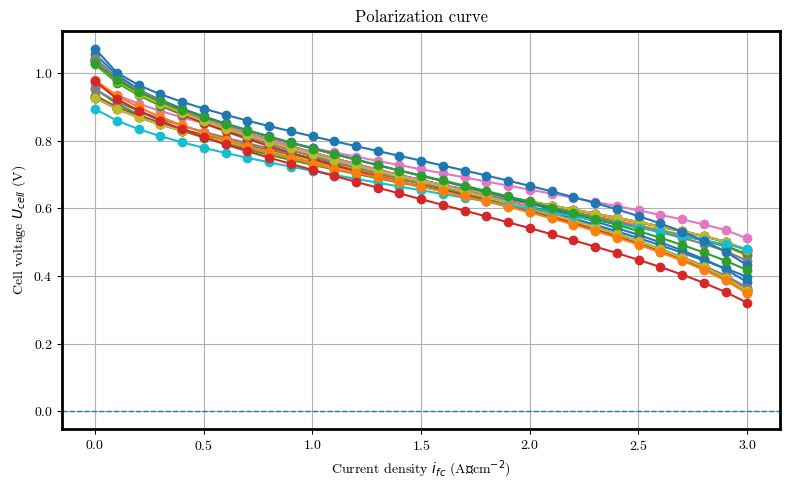

In [40]:
plot_polarization_curves(df_knn_missing,label_mode="index")

We assign the sinthetic curve values

In [41]:
final_df_no_output_cmpl['Ucell'] = ucell_outputs_knn
final_df_no_output_cmpl['ifc'] = ifc_outputs_knn

C:\Users\User\AppData\Local\Temp\ipykernel_15800\3590569045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_no_output_cmpl['Ucell'] = ucell_outputs_knn
C:\Users\User\AppData\Local\Temp\ipykernel_15800\3590569045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_no_output_cmpl['ifc'] = ifc_outputs_knn


Finally we join the dataframe with the original configuration information and the expanded imputed values of `ifc` and `Ucell` for the records with missing current and voltage information

In [43]:
final_df_no_output_cmpl_tmpr = final_df_no_output_cmpl.drop(columns=df_knn_missing.columns.difference(['config_id', 'index']))
final_df_no_output_cmpl_T = final_df_no_output_cmpl_tmpr.merge(df_knn_missing,on=['index', 'config_id'], how='left')
final_df_no_output_cmpl_T.head(3)

,index,config_id,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,...,Ucell_21,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30
0,155,270224541b0577c2209eb38775bac24a95ce68a4438afa...,351.886845,141620.487841,1.167888,0.61256,0.589951,2.806114,0.166173,0.291489,...,0.587679,0.569962,0.551158,0.531802,0.511553,0.490550,0.468516,0.445770,0.422027,0.397222
1,1162,f8618236b03a059484a214652ca26f19ad809cb3a1ff76...,358.404637,249665.979687,1.124174,0.39717,0.564333,3.482001,0.295437,0.251682,...,0.601299,0.588804,0.576235,0.563372,0.550056,0.536143,0.521409,0.505404,0.487052,0.460036
2,1163,1afda288a58c50fdc2b13fc9b1830f5da4768914da6d22...,347.875597,176506.911116,1.124174,0.39717,0.564333,3.482001,0.295437,0.251682,...,0.591214,0.579266,0.567994,0.556620,0.544555,0.531696,0.518166,0.504427,0.488914,0.464214


We unify the valid and invalid curves with the ones we imputed and organized the records by index

In [44]:
final_df_others_cmpl = validated_df.loc[validated_df.classification!="invalid_no_output"]
final_imputed = pd.concat([final_df_others_cmpl,final_df_no_output_cmpl_T],axis=0)
final_imputed = final_imputed.sort_values(by='index')
print(f'Final imputed DataFrame size {final_imputed.shape}')
final_imputed.head(3)

Final imputed DataFrame size (28672, 80)


,index,config_id,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,...,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,classification
0,0,0094c64f8fdda33260ed63c492d142bc880a650b617e77...,345.930884,268442.555293,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.729589,0.720136,0.710694,0.701276,0.691868,0.682447,0.672998,0.663503,0.653945,valid
1,1,732f012ec39bdcb105868dbabddf45c3d1be6262121e97...,350.821056,268442.555293,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.714532,0.707312,0.699526,0.691418,0.682971,0.674209,0.665224,0.656077,0.646728,valid
2,2,9cee6cbca778100f2a177430c2227fac9d62d9ba6514c9...,345.930884,201916.980138,2.632184,0.132074,0.624485,3.519634,0.324444,0.240594,...,0.674898,0.678610,0.672720,0.664524,0.658328,0.651773,0.644676,0.636803,0.628512,valid


In [ ]:
# Save the processed results
pd.DataFrame(final_imputed).to_pickle("../data/processed/imputed_sobol_design_matrix_N1024.pkl")

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3. Running Sobol SA on a specific region

We now compute the Sobol sensitivity indices for one region of the polarization curve.
The curve is split into three parts based on current density:

* **Activation region**: 0.0 – 0.4 A/cm²
* **Ohmic region**: 0.4 – 1.6 A/cm²
* **Mass transport region**: above 1.6 A/cm²

We calculate the area under the curve (AUC) for the selected region.
NOTE: If the voltage becomes negative, we set it to zero before computing the AUC.

Finally, we run the Sobol analysis using the AUC as the target and return the full set of sensitivity indices.


In [ ]:
results_path = "../data/processed/imputed_sobol_design_matrix_N1024.pkl"
df_merged = pd.read_pickle(results_path)
sobol_indices,summary_df = run_sobol_analysis_for_region(SA,df = df_merged, aggregation_method="AUC")
summary_df

[INFO] Running Sobol SA on the AUC of the 'activation' region.
[WARNING] Some S1 indices are negative!
[WARNING] Some S2 indices are negative!
[INFO] Running Sobol SA on the AUC of the 'ohmic' region.
[WARNING] Some S1 indices are negative!
[WARNING] Some S2 indices are negative!
[INFO] Running Sobol SA on the AUC of the 'mass_transport' region.
[WARNING] Some S1 indices are negative!
[WARNING] Some S2 indices are negative!


,activation,ohmic,mass_transport
Sum of S1 indices,0.9848,0.9690,0.9191
Sum of S1 indices (setting negative indices to 0),0.9857,0.9700,0.9251
Sum of second order,-0.1500,-0.1626,-0.1482
Sum of second order (only significant & > 0),0.0000,0.0000,0.0000
Sum of S1 and S2,0.8348,0.8064,0.7709
Sum of significant S1 + significant S2,0.9857,0.9700,0.9251


In [17]:
Si_activation, total_Si_activation, first_Si_activation, second_Si_activation= sobol_indices['activation']
Si_ohmic, total_Si_ohmic, first_Si_ohmic, second_Si_ohmic = sobol_indices['ohmic']
Si_mass, total_Si_mass, first_Si_mass, second_Si_mass= sobol_indices['mass_transport']

### Convergence plots

In [18]:
sobol_convergence_for_region = run_sobol_convergence_analysis_for_region(SA, df= df_merged, step=2, max_N=1024, index_type="ST")
sobol_convergence_activation,sobol_convergence_ohmic,sobol_convergence_mass = sobol_convergence_for_region

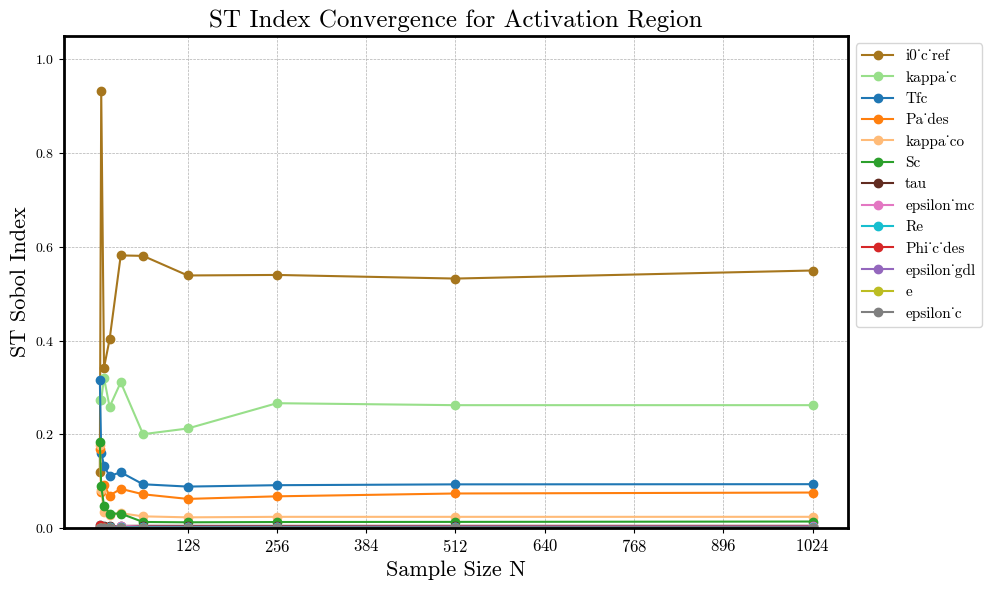

In [19]:
# Plot convergence
plot_sobol_index_convergence(sobol_convergence_activation, index_type="ST", region="activation", top_k=13)

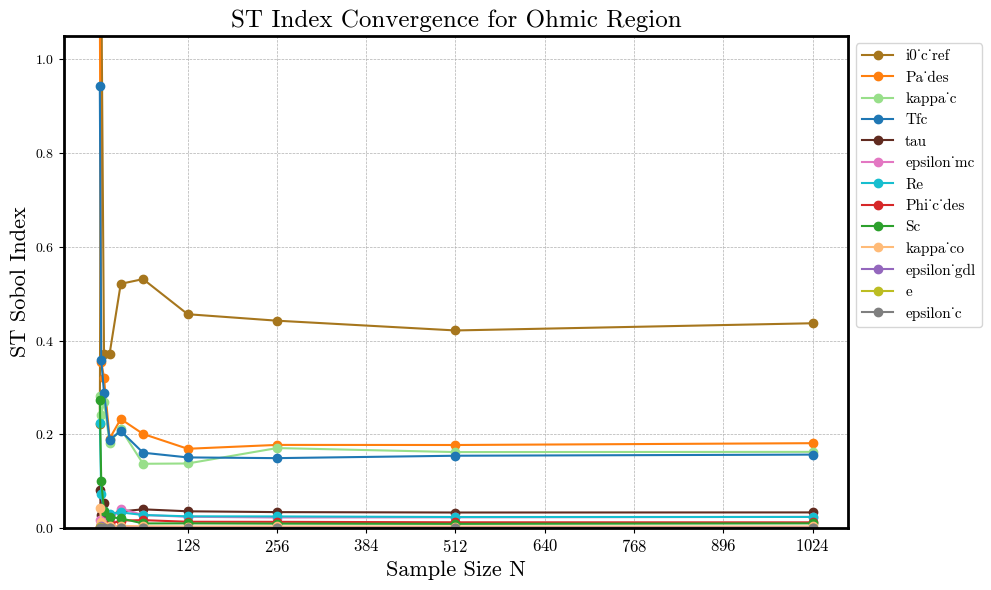

In [20]:

# Plot convergence
plot_sobol_index_convergence(sobol_convergence_ohmic, index_type="ST", region="ohmic", top_k=13)

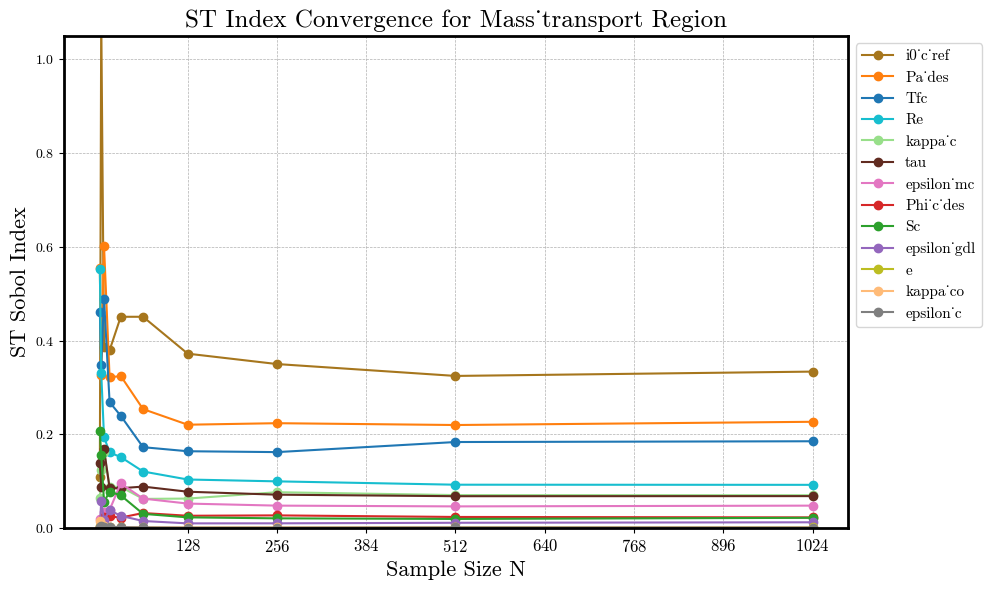

In [22]:

# Plot convergence
plot_sobol_index_convergence(sobol_convergence_mass, index_type="ST", region="mass_transport", top_k=13)

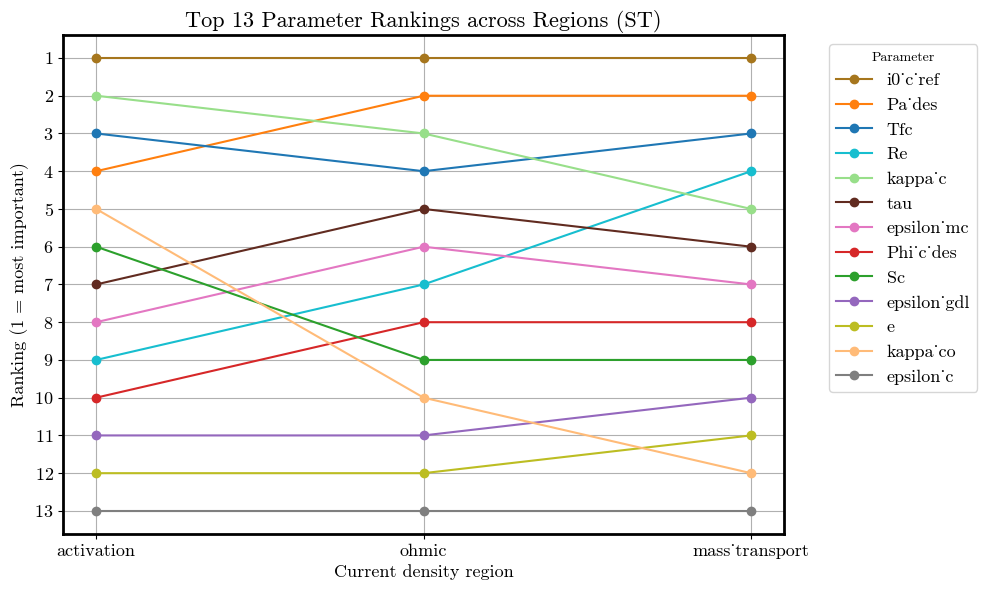

In [23]:
# Extract final ST DataFrame from each convergence result
rank_sources_st = {
    "activation": sobol_convergence_activation[max(sobol_convergence_activation.keys())]["sobol_df"],
    "ohmic": sobol_convergence_ohmic[max(sobol_convergence_ohmic.keys())]["sobol_df"],
    "mass_transport": sobol_convergence_mass[max(sobol_convergence_mass.keys())]["sobol_df"]
}

plot_top_k_rankings_across_regions(
    rank_sources=rank_sources_st,
    source_type="ST",        # Choose "S1", "ST", or "shap"
    top_k=13,                # How many top features to track
    figsize=(10, 6)
)

In [24]:
# Run convergence for activation region S1
sobol_convergence_for_region_S1 = run_sobol_convergence_analysis_for_region(SA, df= df_merged, step=2, max_N=1024, index_type="S1")
sobol_convergence_activation_S1,sobol_convergence_ohmic_S1,sobol_convergence_mass_S1 = sobol_convergence_for_region_S1

In [25]:
sobol_convergence_mass_S1[max(sobol_convergence_mass_S1.keys())]["sobol_df"].sort_values(by = "S1")

,S1,S1_conf,feature
epsilon_c,-0.002465,0.002159,epsilon_c
Sc,-0.001834,0.012490,Sc
epsilon_gdl,-0.001698,0.008562,epsilon_gdl
kappa_co,0.000227,0.004003,kappa_co
e,0.002527,0.003126,e
Phi_c_des,0.008449,0.012001,Phi_c_des
epsilon_mc,0.038071,0.017886,epsilon_mc
kappa_c,0.044518,0.023477,kappa_c
tau,0.064255,0.026456,tau
Re,0.092923,0.027962,Re


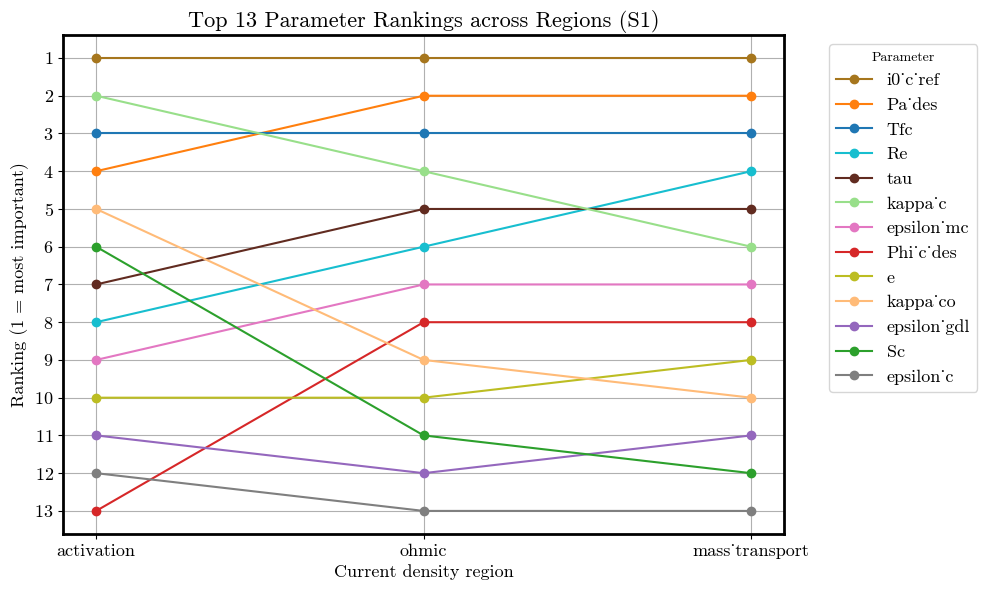

In [26]:
# Extract final ST DataFrame from each convergence result
rank_sources_s1 = {
    "activation": sobol_convergence_activation_S1[max(sobol_convergence_activation_S1.keys())]["sobol_df"],
    "ohmic": sobol_convergence_ohmic_S1[max(sobol_convergence_ohmic_S1.keys())]["sobol_df"],
    "mass_transport": sobol_convergence_mass_S1[max(sobol_convergence_mass_S1.keys())]["sobol_df"]
}

plot_top_k_rankings_across_regions(
    rank_sources=rank_sources_s1,
    source_type="S1",        # Choose "S1", "ST", or "shap"
    top_k=13,                # How many top features to track
    figsize=(10, 6)
)

## Plots for Final Presentation
In this section, we present the plots and summaries used in the final presentation.

1. **Detailed Sobol First and Second -Order Indices:**
We begin by showing the detailed values of the first and second-order Sobol indices for each feature.

In [40]:
first_Si_activation.sort_values(by = "S1", ascending = False)

,S1,S1_conf,CI_lower,CI_upper,CI_contains_0
i0_c_ref,0.560704,0.078026,0.482678,0.638730,False
kappa_c,0.233810,0.043683,0.190127,0.277494,False
Tfc,0.088297,0.029088,0.059209,0.117385,False
Pa_des,0.061433,0.022099,0.039334,0.083532,False
kappa_co,0.024021,0.013744,0.010277,0.037765,False
Sc,0.007272,0.009364,-0.002093,0.016636,True
tau,0.004846,0.006397,-0.001551,0.011242,True
Re,0.002771,0.003993,-0.001222,0.006764,True
epsilon_mc,0.002298,0.004931,-0.002634,0.007229,True
e,0.000259,0.000272,-0.000013,0.000531,True


In [36]:
second_Si_activation.sort_values(by = "S2", ascending = False)

,S2,S2_conf,CI_lower,CI_upper,CI_contains_0
"(Tfc, i0_c_ref)",0.008026,0.053093,-0.045067,0.061120,True
"(Pa_des, kappa_c)",0.006145,0.035215,-0.029070,0.041361,True
"(Sc, kappa_c)",0.003848,0.015460,-0.011612,0.019308,True
"(Sc, epsilon_mc)",0.003681,0.014092,-0.010412,0.017773,True
"(epsilon_mc, i0_c_ref)",0.003531,0.009164,-0.005633,0.012695,True
...,...,...,...,...,...
"(Pa_des, epsilon_gdl)",-0.018466,0.030655,-0.049120,0.012189,True
"(Pa_des, Re)",-0.018546,0.030449,-0.048995,0.011903,True
"(Pa_des, kappa_co)",-0.018726,0.030512,-0.049237,0.011786,True
"(i0_c_ref, kappa_c)",-0.020171,0.137022,-0.157193,0.116850,True


2. **Regional Summary Table:**
We have the first-order and total-order Sobol indices per region. These results are organized into a summary table that also includes the rank of each feature within each region.

In [ ]:
region_to_df_S1 = {"activation": first_Si_activation,"ohmic": first_Si_ohmic,"mass_transport": first_Si_mass}
region_to_df_ST = {"activation": total_Si_activation,"ohmic": total_Si_ohmic,"mass_transport": total_Si_mass}

# Order in the presentation
param_order = ["Tfc", "Pa_des", "Sc", "Phi_c_des", "epsilon_gdl", "tau", "epsilon_mc","epsilon_c", "e", "Re", "i0_c_ref", "kappa_co", "kappa_c"]

In [21]:
summary_table_S1 = build_sobol_summary_table(region_to_df_S1, param_order, index_type="S1")
summary_table_S1

,activation_value,ohmic_value,mass_transport_value,activation_rank,ohmic_rank,mass_transport_rank
Parameter,,,,,,
Tfc,0.088 ± 0.03,0.141 ± 0.04,0.153 ± 0.04,3,3,3
Pa_des,0.061 ± 0.02,0.165 ± 0.04,0.188 ± 0.04,4,2,2
Sc,0.007 ± 0.01,0.000 ± 0.01,-0.002 ± 0.01,6,11,12
Phi_c_des,-0.001 ± 0.00,0.005 ± 0.01,0.008 ± 0.01,13,8,8
epsilon_gdl,-0.000 ± 0.00,-0.000 ± 0.00,-0.002 ± 0.01,11,12,11
tau,0.005 ± 0.01,0.031 ± 0.02,0.064 ± 0.03,7,5,5
epsilon_mc,0.002 ± 0.00,0.016 ± 0.01,0.038 ± 0.02,9,7,7
epsilon_c,-0.000 ± 0.00,-0.001 ± 0.00,-0.002 ± 0.00,12,13,13
e,0.000 ± 0.00,0.001 ± 0.00,0.003 ± 0.00,10,10,9


In [34]:
summary_table_ST = build_sobol_summary_table(region_to_df_S1, param_order, index_type="S1")
summary_table_ST

,activation_value,ohmic_value,mass_transport_value,activation_rank,ohmic_rank,mass_transport_rank
Parameter,,,,,,
Tfc,0.085 ± 0.03,0.133 ± 0.03,0.144 ± 0.04,3,4,3
Pa_des,0.059 ± 0.02,0.156 ± 0.04,0.176 ± 0.04,4,2,2
Sc,0.008 ± 0.01,0.000 ± 0.01,-0.002 ± 0.01,6,11,11
Phi_c_des,0.000 ± 0.00,0.004 ± 0.01,0.005 ± 0.01,13,8,8
epsilon_gdl,0.001 ± 0.00,-0.001 ± 0.00,-0.005 ± 0.01,11,12,12
tau,0.005 ± 0.01,0.030 ± 0.02,0.062 ± 0.02,7,5,5
epsilon_mc,0.002 ± 0.01,0.015 ± 0.01,0.037 ± 0.02,10,7,7
epsilon_c,0.001 ± 0.00,-0.001 ± 0.00,-0.005 ± 0.00,12,13,13
e,0.004 ± 0.01,0.003 ± 0.02,-0.000 ± 0.01,8,9,10


3. **Bar Plot of Sobol Indices by Region**
- We visualize the Sobol indices per region using bar plots.
- Confidence intervals are included to illustrate the uncertainty in the index estimates.

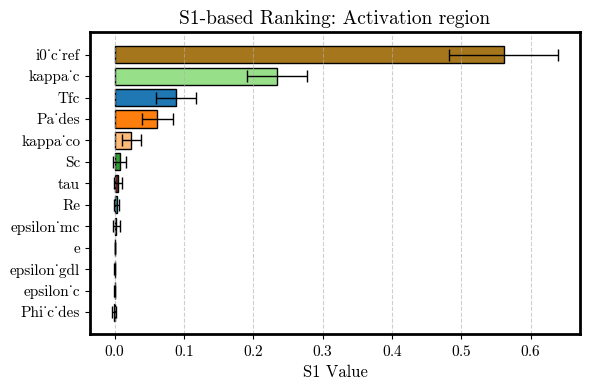

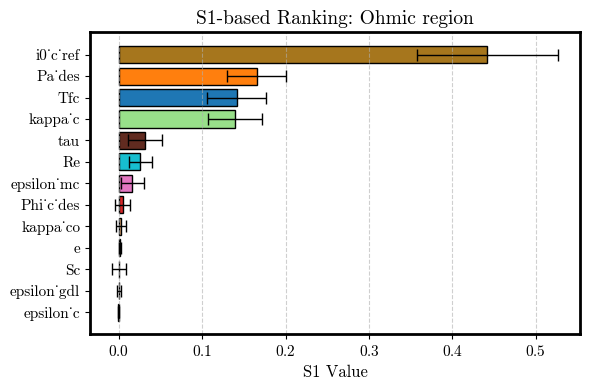

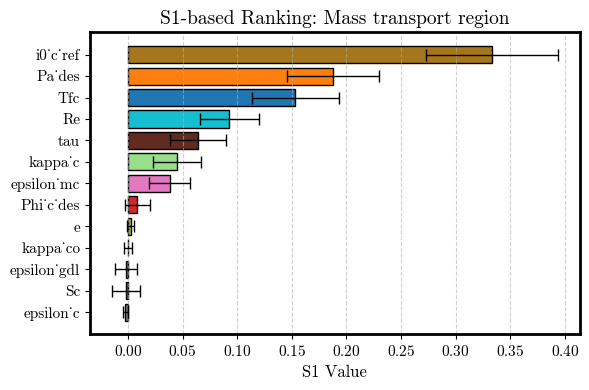

In [22]:
plot_sobol_region_barplot(first_Si_activation, region="activation", index_type="S1", top_k = 13)
plot_sobol_region_barplot(first_Si_ohmic, region="ohmic", index_type="S1", top_k = 13)
plot_sobol_region_barplot(first_Si_mass, region="mass transport", index_type="S1", top_k = 13)

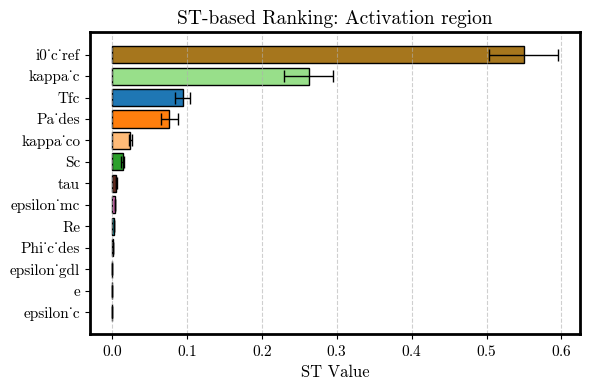

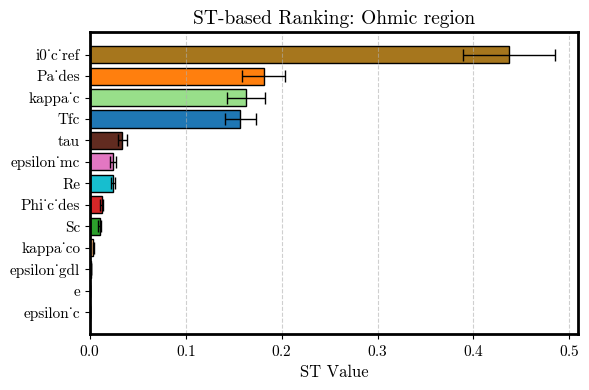

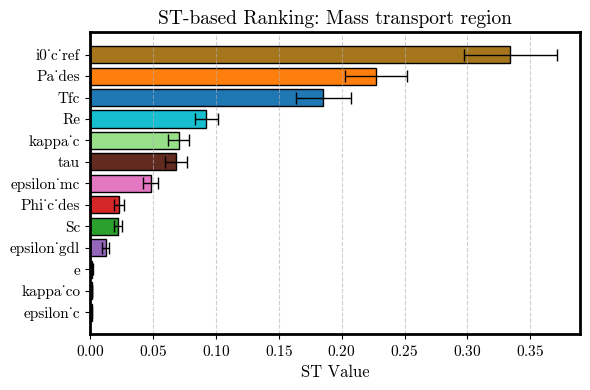

In [32]:
plot_sobol_region_barplot(total_Si_activation, region="activation", index_type="ST", top_k = 13)
plot_sobol_region_barplot(total_Si_ohmic, region="ohmic", index_type="ST", top_k = 13)
plot_sobol_region_barplot(total_Si_mass, region="mass transport", index_type="ST", top_k = 13)

4. **Selection of Most Relevant Features**
We identify the set of features that together explain at least 85% of the variance in each region.
These features are combined to produce a final list of the most relevant ones across all regions.

In [37]:
# Extract final ST DataFrame from each convergence result
rank_sources_s1 = {
    "activation": first_Si_activation.reset_index().rename(columns = {"index": "feature"}),
    "ohmic": first_Si_ohmic.reset_index().rename(columns = {"index": "feature"}),
    "mass_transport": first_Si_mass.reset_index().rename(columns = {"index": "feature"})
}
select_top_features(rank_sources=rank_sources_s1, source_type="S1", method="threshold", threshold=0.85)


Region: activation
Selected 3 features using method='threshold' (threshold=0.85)
Total importance explained: 0.883
Selected features: ['i0_c_ref', 'kappa_c', 'Tfc']

Region: ohmic
Selected 4 features using method='threshold' (threshold=0.85)
Total importance explained: 0.888
Selected features: ['i0_c_ref', 'Pa_des', 'Tfc', 'kappa_c']

Region: mass_transport
Selected 6 features using method='threshold' (threshold=0.85)
Total importance explained: 0.876
Selected features: ['i0_c_ref', 'Pa_des', 'Tfc', 'Re', 'tau', 'kappa_c']

Union of all selected features across regions: ['Pa_des', 'Re', 'Tfc', 'i0_c_ref', 'kappa_c', 'tau']
Total unique features selected: 6


({'activation': ['i0_c_ref', 'kappa_c', 'Tfc'],
  'ohmic': ['i0_c_ref', 'Pa_des', 'Tfc', 'kappa_c'],
  'mass_transport': ['i0_c_ref', 'Pa_des', 'Tfc', 'Re', 'tau', 'kappa_c']},
 {'Pa_des', 'Re', 'Tfc', 'i0_c_ref', 'kappa_c', 'tau'})